<a href="https://colab.research.google.com/github/rajayarli/SIT708-HD/blob/master/hd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import random

import tensorflow_datasets as tfds


print(tf.__version__)

2.12.0


In [ ]:
# Keras provides a handy API to download the MNIST dataset, and split them into
# "train" dataset and "test" dataset.
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images / 255.0
test_images = test_images / 255.0
print('Pixels are normalized')

Pixels are normalized


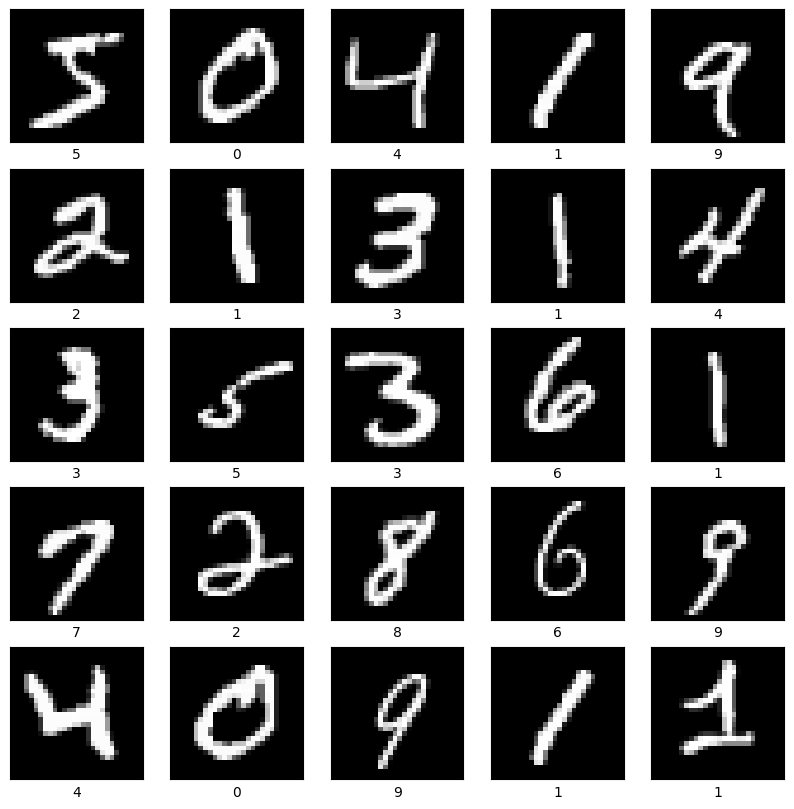

In [ ]:
# Show the first 25 images in the training dataset.
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_images[i], cmap=plt.cm.gray)
  plt.xlabel(train_labels[i])
plt.show()

In [ ]:
class PrototypicalNetworks(tf.keras.Model):
    def __init__(self):
        super(PrototypicalNetworks, self).__init__()
        # Define your model architecture here

    def call(self, inputs):
        # Implement the forward pass of your model here
        return logits


In [ ]:
class PrototypicalNetworks(tf.keras.Model):
    def __init__(self):
        super(PrototypicalNetworks, self).__init__()
        self.model = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(28, 28)),
            tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation=tf.nn.relu),
            tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation=tf.nn.relu),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Dropout(0.25),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(10)
        ])

    def call(self, inputs):
        return self.model(inputs)


In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Evaluate the model using all images in the test dataset
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)


313/313 [==============================] - 8s 25ms/step - loss: 0.0781 - accuracy: 0.9752
Test accuracy: 0.9751999974250793


In [ ]:
# Define the number of classes for few-shot learning
num_classes = 5

# Instantiate the Prototypical Networks model
model = PrototypicalNetworks()

# Define the loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Define the optimizer
optimizer = tf.keras.optimizers.Adam()

# Define the number of episodes and shots per class
num_episodes = 1000
num_support_shots = 5
num_query_shots = 5

# Start the training loop
for episode in range(num_episodes):
    # Sample a few classes for the episode
    classes = np.random.choice(range(10), size=num_classes, replace=False)
    
    # Initialize support and query sets
    support_set = []
    query_set = []
    
    # Collect support and query examples for each class
    for class_label in classes:
        class_samples = np.random.choice(
            np.where(train_labels == class_label)[0],
            size=num_support_shots + num_query_shots,
            replace=False
        )
        support_set.extend([(train_images[i], train_labels[i]) for i in class_samples[:num_support_shots]])
        query_set.extend([(train_images[i], train_labels[i]) for i in class_samples[num_support_shots:]])
    
    # Prepare the support and query data
    support_images, support_labels = zip(*support_set)
    query_images, query_labels = zip(*query_set)
    
    # Convert the data to TensorFlow tensors
    support_images = tf.stack(support_images)
    support_labels = tf.stack(support_labels)
    query_images = tf.stack(query_images)
    query_labels = tf.stack(query_labels)
    
    # Forward pass on the support set to compute class prototypes
    with tf.GradientTape() as tape:
        support_logits = model(support_images, training=True)
        support_loss = loss_fn(support_labels, support_logits)
    
    # Compute gradients and update the model parameters
    gradients = tape.gradient(support_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    # Forward pass on the query set for evaluation
    query_logits = model(query_images, training=False)
    query_loss = loss_fn(query_labels, query_logits)
    
    # Print the loss for each episode
    print('Episode {}: Support Loss = {:.4f}, Query Loss = {:.4f}'.format(
        episode+1, support_loss, query_loss))


Episode 1: Support Loss = 2.2964, Query Loss = 2.1270
Episode 2: Support Loss = 2.2106, Query Loss = 2.0758
Episode 3: Support Loss = 2.4147, Query Loss = 2.3230
Episode 4: Support Loss = 2.2428, Query Loss = 2.1846
Episode 5: Support Loss = 2.1366, Query Loss = 2.0298
Episode 6: Support Loss = 2.1920, Query Loss = 2.1389
Episode 7: Support Loss = 2.2644, Query Loss = 2.1792
Episode 8: Support Loss = 2.3604, Query Loss = 2.3076
Episode 9: Support Loss = 2.1513, Query Loss = 2.0642
Episode 10: Support Loss = 2.2147, Query Loss = 2.1461
Episode 11: Support Loss = 2.1846, Query Loss = 2.1884
Episode 12: Support Loss = 2.0048, Query Loss = 1.9218
Episode 13: Support Loss = 2.1478, Query Loss = 2.1183
Episode 14: Support Loss = 2.1994, Query Loss = 2.1368
Episode 15: Support Loss = 1.8618, Query Loss = 1.8555
Episode 16: Support Loss = 1.6598, Query Loss = 1.5577
Episode 17: Support Loss = 1.6938, Query Loss = 1.5602
Episode 18: Support Loss = 1.9213, Query Loss = 1.8428
Episode 19: Support

In [ ]:
model.summary()

Model: "prototypical_networks_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 10)                110986    
                                                                 
Total params: 110,986
Trainable params: 110,986
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Evaluate the model using all images in the test dataset
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)


313/313 [==============================] - 8s 25ms/step - loss: 0.0781 - accuracy: 0.9752
Test accuracy: 0.9751999974250793


313/313 [==============================] - 10s 32ms/step


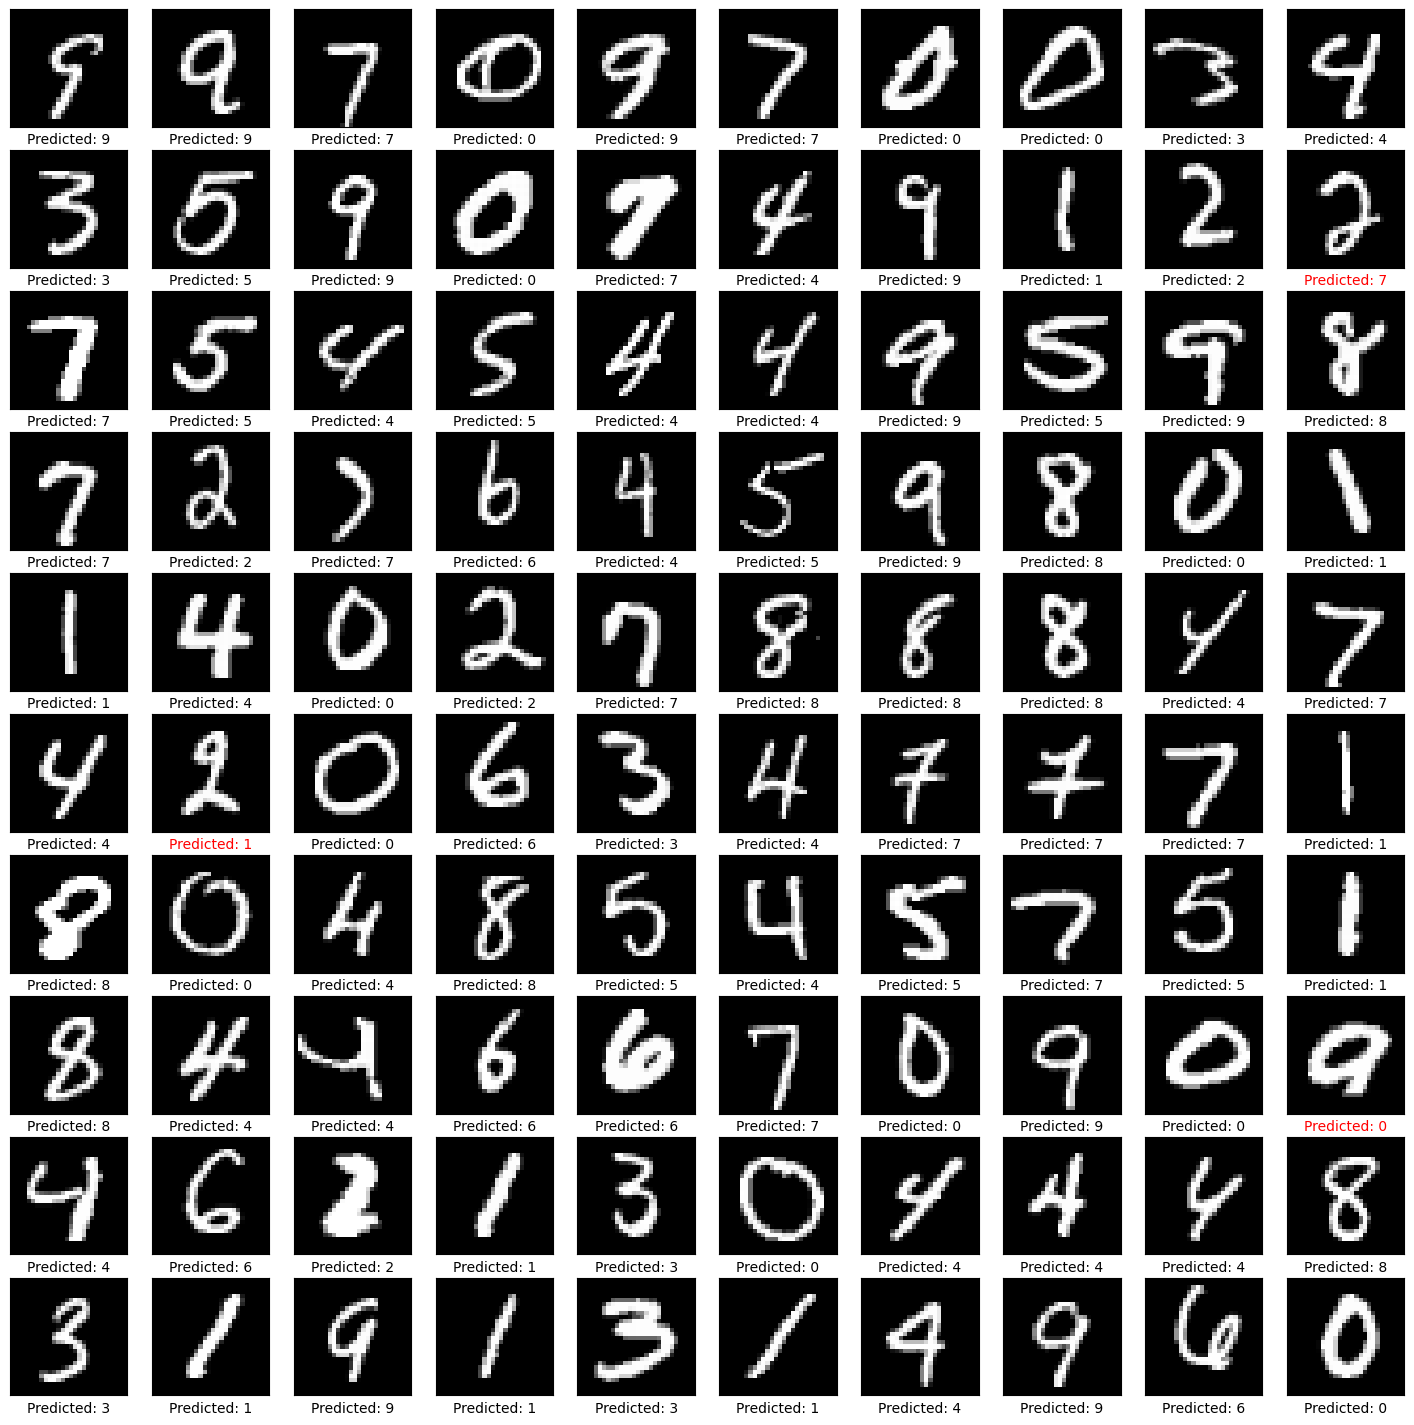

In [ ]:
# A helper function that returns 'red'/'black' depending on if its two input
# parameter matches or not.
def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'

# Predict the labels of digit images in our test dataset.
predictions = model.predict(test_images)

# As the model output 10 float representing the probability of the input image
# being a digit from 0 to 9, we need to find the largest probability value
# to find out which digit the model predicts to be most likely in the image.
prediction_digits = np.argmax(predictions, axis=1)

# Then plot 100 random test images and their predicted labels.
# If a prediction result is different from the label provided label in "test"
# dataset, we will highlight it in red color.
plt.figure(figsize=(18, 18))
for i in range(100):
  ax = plt.subplot(10, 10, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  image_index = random.randint(0, len(prediction_digits))
  plt.imshow(test_images[image_index], cmap=plt.cm.gray)
  ax.xaxis.label.set_color(get_label_color(prediction_digits[image_index],\
                                           test_labels[image_index]))
  plt.xlabel('Predicted: %d' % prediction_digits[image_index])
plt.show()

In [ ]:
# Convert Keras model to TF Lite format.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_float_model = converter.convert()

# Show model size in KBs.
float_model_size = len(tflite_float_model) / 1024
print('Float model size = %dKBs.' % float_model_size)

Float model size = 437KBs.


In [ ]:
# Re-convert the model to TF Lite using quantization.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

# Show model size in KBs.
quantized_model_size = len(tflite_quantized_model) / 1024
print('Quantized model size = %dKBs,' % quantized_model_size)
print('which is about %d%% of the float model size.'\
      % (quantized_model_size * 100 / float_model_size))

Quantized model size = 114KBs,
which is about 26% of the float model size.


In [ ]:
# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_tflite_model(tflite_model):
  # Initialize TFLite interpreter using the model.
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()
  input_tensor_index = interpreter.get_input_details()[0]["index"]
  output = interpreter.tensor(interpreter.get_output_details()[0]["index"])

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for test_image in test_images:
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_tensor_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  # Compare prediction results with ground truth labels to calculate accuracy.
  accurate_count = 0
  for index in range(len(prediction_digits)):
    if prediction_digits[index] == test_labels[index]:
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_digits)

  return accuracy

# Evaluate the TF Lite float model. You'll find that its accurary is identical
# to the original TF (Keras) model because they are essentially the same model
# stored in different format.
float_accuracy = evaluate_tflite_model(tflite_float_model)
print('Float model accuracy = %.4f' % float_accuracy)

# Evalualte the TF Lite quantized model.
# Don't be surprised if you see quantized model accuracy is higher than
# the original float model. It happens sometimes :)
quantized_accuracy = evaluate_tflite_model(tflite_quantized_model)
print('Quantized model accuracy = %.4f' % quantized_accuracy)
print('Accuracy drop = %.4f' % (float_accuracy - quantized_accuracy))


Float model accuracy = 0.9752
Quantized model accuracy = 0.9752
Accuracy drop = 0.0000


In [ ]:
# Save the quantized model to file to the Downloads directory
f = open('mnist.tflite', "wb")
f.write(tflite_quantized_model)
f.close()

# Download the digit classification model
from google.colab import files
files.download('mnist.tflite')

print('`mnist.tflite` has been downloaded')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

`mnist.tflite` has been downloaded
